# Machine Learning and Predictive Analytics

In this notebook we will be training some machine learning algorithms with our processed data to try to predict the Fraudulent transactions. We will firt make some transformations to the data so that it fits the models and then we will train them and evaluate their performance.

# Index

In this notebook, we will train the data (*transactions_processed.csv*) and evaluate the performance of different models. The steps that we will follow are:

1. **Import Libraries**
2. **Data Transformation**
    - **2.1 Discretize variables**
    - **2.2 Normalize variables**
    - **2.3 Encode variables**
    - **2.4 Fraction the data**
    - **2.5 Split the data**
    - **2.6 Sampling the data**
3. **Model Training and Evaluation**
4. **Conclusion**


## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import boxcox ,probplot
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , roc_auc_score, f1_score, recall_score 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN


import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:
os.chdir('..')
# original dataset
path = os.getcwd()+'/data/transactions_processed.csv'
# small dataset
# path = os.getcwd()+'/data/transactions_processed_2.csv'

df = pd.read_csv(path, encoding='UTF-8')

## 2. Data Transformation:

### 2.1 Discretize variables  
As we have seen in the EDA notebook the variable 'Account Age' and 'Transaction Hour' is more likely to be fraudulent when they are in certain ranges. We will discretize these variables to see if the models can capture this information. 

In [3]:
# Define bins and labels for Account Age Days
account_age_bins = [0, 30, 90, 180, 366]
account_age_labels = ['1-3 months', '3-6 months', '6-9 months' ,'6-12 months']
# Create new column with the binned data for Account Age Days
df['Account Age Range'] = pd.cut(df['Account Age Days'], bins=account_age_bins, labels=account_age_labels, right=False).astype('object')

# Define bins and labels for Transaction Hour
transaction_hour_bins = [0, 6, 12, 18, 24]
transaction_hour_labels = ['Dawn', 'Morning', 'Afternoon', 'Evening']

# Create new column with the binned data for Transaction Hour
df['Transaction Hour Range'] = pd.cut(df['Transaction Hour'], bins=transaction_hour_bins, labels=transaction_hour_labels, right=False).astype('object')

# Drop the original columns
df.drop(columns=['Account Age Days','Transaction Hour'], axis=1, inplace=True)

### 2.2 Normalize variables  
Another thing that we need is a transformation of the column 'Transaction Amount', because this distribution is right-skewed. we will apply a box-cox transformation to make it more normal. and do a test to check if the transformation was successful.

Lambda used for Box-Cox transformation: 0.09284324748066126


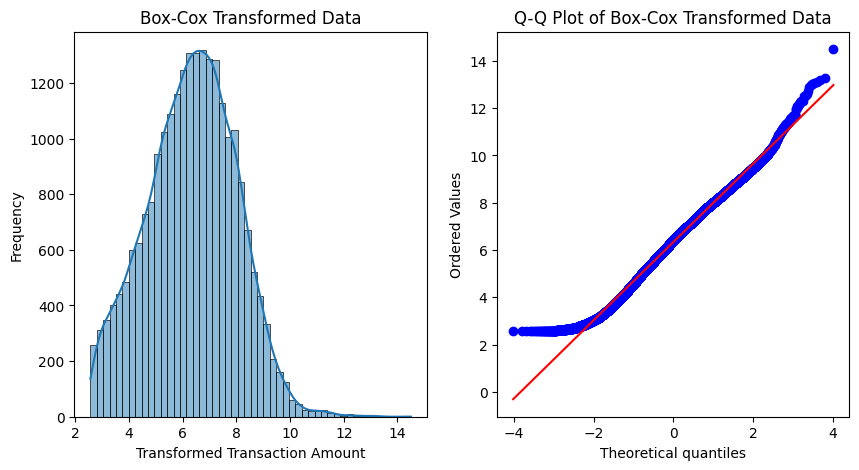

In [4]:
# Get the lambda value for Box-Cox transformation
_, lam = boxcox(df['Transaction Amount'])
print(f"Lambda used for Box-Cox transformation: {lam}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(_, bins=50, kde=True)
plt.title('Box-Cox Transformed Data')
plt.xlabel('Transformed Transaction Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
probplot(_, dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Data')

plt.show()

### 2.3 Encode variables

First start with the data transformation.
 - for the categorical columns, we will use the OneHotEncoder, to transform the categorical columns into numerical columns.
 - for the numerical columns, because the box-cox transformation do the normalization as we see before

In [5]:
# Define the categorical and numeric features
cate_features = ['Transaction Hour Range', 'Account Age Range','Payment Method', 'Product Category', 'Quantity', 'Customer Age', 'Device Used']
num_features = ['Transaction Amount']

# Box-Cox transformation function for use in the pipeline
def boxcox_transform(X, lmbda):
    return boxcox(X, lmbda=lmbda)

# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cate_features),
        ('num', FunctionTransformer(boxcox_transform, kw_args={'lmbda': lam}), num_features)
    ])

### 2.4 Fraction the data
Since the dataset is really large and the proportion of fraudulent transactions is really low, we will sample the data to make the training process faster. We will use 10% of the data for training. mantain the same proportion of fraudulent transactions. and we will use another technique to balance the data.

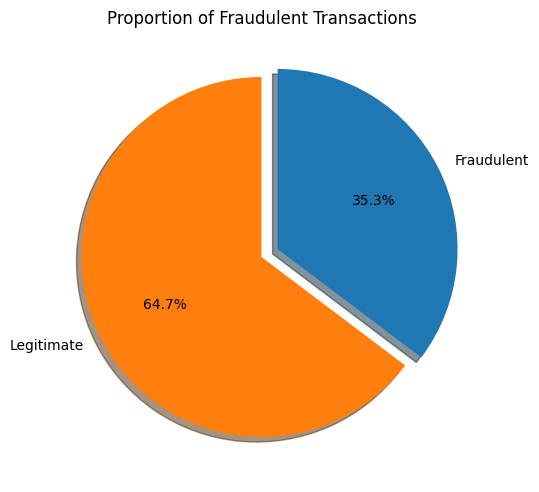

In [6]:
# Sample the data to balance the classes (fraudulent and non-fraudulent) maintaining the proportion of fraudulent transactions
df= pd.concat([df[df['Is Fraudulent'] == 1], df[df['Is Fraudulent'] == 0].sample(frac=0.1, random_state=42)])

# Shuffle the data
df= df.sample(frac=1, random_state=42)

# Reset index
df.reset_index(drop=True, inplace=True)

df.shape

# Plot the proportion of fraudulent transactions
fig = plt.pie(df['Is Fraudulent'].value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', startangle=90 , colors = ['#FF7F0E', '#1F77B4'], explode=(0, 0.1) ,shadow=True)
plt.tight_layout() # set the size of the graph
plt.title('Proportion of Fraudulent Transactions')
plt.show()

### 2.5 Split the data
We divide the data into training and testing sets. The training set is used to train the model, while the testing set is used to evaluate the model's performance on unseen data. We use the train_test_split method from the sklearn library to split the data. We will use 70% of the data for training and 30% for testing, given the large size of the dataset. We also set a random seed (random_state) to ensure reproducibility.

In [7]:
# define the features and target variable.
X = df.drop(['Is Fraudulent'], axis=1)
y = df['Is Fraudulent']

# split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

### 2.6 Sampling the data

Now we do a series of steps to prepare the train data for the model:
- Because we have a problem with the class imbalance, we will use a Sampling technique to balance the classes, let's see choose the best sampling technique on respect the F1 score.

In [8]:
def evaluate_sampling_techniques(X_train, y_train, X_test, y_test, column_transformer):
    '''
    Function that evaluates different sampling techniques for a binary classification model using logistic regression, 
    and returns a DataFrame with the obtained results. It includes oversampling, undersampling, and combinations techniques, 
    and identifies the best result based on the F1 score.

    Parameters:
    - X_train (pd.DataFrame): Features of the training set.
    - y_train (pd.Series): Target variable of the training set.
    - X_test (pd.DataFrame): Features of the testing set.
    - y_test (pd.Series): Target variable of the testing set.
    - column_transformer (ColumnTransformer): Transformer for preprocessing the features.

    Samplings Techniques:
    - Oversampling: SMOTE, ADASYN, RandomOverSampler.
    - Undersampling: TomekLinks, NearMiss, RandomUnderSampler, EditedNearestNeighbours.
    - Combine-sampling: SMOTETomek, SMOTEENN.

    Steps:
    1. Define the logistic regression model.
    2. Define oversampling, undersampling, and combination techniques.
    3. Evaluate each technique individually.
    4. Collect metrics (ROC AUC, accuracy, F1 score, recall) for each method.
    5. Identify and print the best result based on the F1 score.
    6. Return the transformed X_train ,X_test , y_train , y_test using the best sampling technique.

    Returns:
    - np.array: Transformed X_train using the best sampling technique.
    - np.array: Transformed y_train using the best sampling technique.
    - np.array: Transformed X_test using the best sampling technique.
    - np.array: Transformed y_test using the best sampling technique.
    '''

    # Data transformation
    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)
    
    # Define the model
    model = LogisticRegression(solver='liblinear')

    # Define oversampling techniques
    over_sampling_methods = {
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'RandomOverSampler': RandomOverSampler(random_state=42)
    }

    # Define undersampling techniques
    under_sampling_methods = {
        'TomekLinks': TomekLinks(),
        'NearMiss': NearMiss(),
        'RandomUnderSampler': RandomUnderSampler(random_state=42),
        'EditedNearestNeighbour': EditedNearestNeighbours(n_neighbors=3)
    }

    # Define combine-sampling techniques
    combine_sampling_methods = {
        'SMOTETomek': SMOTETomek(random_state=42, smote=SMOTE(sampling_strategy='minority'), tomek=TomekLinks(sampling_strategy='majority')),
        'SMOTEENN': SMOTEENN(random_state=42, smote=SMOTE(sampling_strategy='minority'), enn=EditedNearestNeighbours(sampling_strategy='majority'))
    }

    results = []
    best_f1_score = 0
    best_sampler = None

    # Evaluate without sampling
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    results.append({'Method': 'None', 'Type': 'None', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})

    if f1 > best_f1_score:
        best_f1_score = f1
        best_sampler = None

    # Evaluate oversampling
    for method_name, sampler in over_sampling_methods.items():
        pipeline = ImbPipeline([('sampler', sampler), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Oversampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_sampler = sampler

    # Evaluate undersampling
    for method_name, sampler in under_sampling_methods.items():
        pipeline = ImbPipeline([('sampler', sampler), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Undersampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_sampler = sampler

    # Evaluate combine-sampling
    for method_name, sampler in combine_sampling_methods.items():
        pipeline = ImbPipeline([('sampler', sampler), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Combine-sampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_sampler = sampler

    results_df = pd.DataFrame(results)
    best_result = results_df.loc[results_df['F1'].idxmax()]
    print("Best result based on F1 score:")
    print(best_result)
    print(results_df.head())

    if best_sampler is not None:
        X_train_resampled, y_train_resampled = best_sampler.fit_resample(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    return X_train_resampled, y_train_resampled, X_test, y_test

Best result based on F1 score:
Method             SMOTE
Type        Oversampling
ROC AUC         0.752423
Accuracy        0.764791
F1              0.681018
Recall          0.710204
Name: 1, dtype: object
              Method           Type   ROC AUC  Accuracy        F1    Recall
0               None           None  0.722481  0.769120  0.633028  0.563265
1              SMOTE   Oversampling  0.752423  0.764791  0.681018  0.710204
2             ADASYN   Oversampling  0.749426  0.756133  0.678095  0.726531
3  RandomOverSampler   Oversampling  0.746301  0.760462  0.673228  0.697959
4         TomekLinks  Undersampling  0.729656  0.760462  0.648305  0.624490


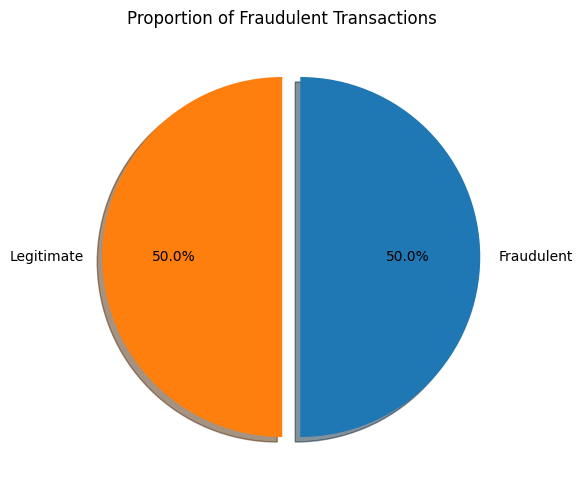

In [9]:
X_train , y_train, X_test, y_test = evaluate_sampling_techniques(X_train , y_train, X_test, y_test , column_transformer)

# Plot the proportion of fraudulent transactions
fig = plt.pie(y_train.value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', startangle=90 , colors = ['#FF7F0E', '#1F77B4'], explode=(0, 0.1) ,shadow=True)
plt.tight_layout() # set the size of the graph
plt.title('Proportion of Fraudulent Transactions')
plt.show()

As we can see the best sampling technique is the SMOTETomek, so we will use this technique to balance the classes.

## 3. Model Training and Evaluation

We will train the following models:
- Logistic Regression
- Random Forest
- Balanced Random Forest
- Easy Ensemble Classifier
- LGBMClassifier
- XGBClassifier
- GradientBoostingClassifier
- AdaBoostClassifier
- KNeighborsClassifier

And get the best model based on the F1 score.

In [10]:
X_train = X_train.toarray()
X_test = X_test.toarray()


In [11]:
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = {
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Train and evaluate each model ON THE TEST SET and find the best one
print("Test set evaluation scores:")
best_test_model = None
best_test_score = 0
best_test_model_name = ""


for name, model in models.items():
    pipeline = Pipeline([ # create a pipeline with the column transformer, scaler, and classifier
        # ('preprocess', column_transformer),
        ('classifier', model)
    ])
    start_time = time.time() 
    pipeline.fit(X_train, y_train) # train the model
    training_time = time.time() - start_time # measure the time taken to train the model
    y_pred = pipeline.predict(X_test) # make predictions

    accuracy = accuracy_score(y_test, y_pred) # calculate the accuracy
    f1 = f1_score(y_test, y_pred)# Calculate F1 score
    confusion = confusion_matrix(y_test, y_pred) # calculate the confusion matrix
    classification = classification_report(y_test, y_pred) # calculate the classification report
    
    # The output shows the accuracy, confusion matrix, and classification report for each model, helping to compare their performance in a more detailed way.
    print("\n" + "="*60 + "\n")
    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Classification Report:\n{classification}")
    print(f"Training Time: {training_time:.4f} seconds")

    if f1 > best_test_score:
        best_test_score = f1
        best_test_model = pipeline
        best_test_model_name = name


Test set evaluation scores:


Results for LDA:
Accuracy: 0.7619
F1 Score: 0.6746
Confusion Matrix:
[[357  91]
 [ 74 171]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       448
           1       0.65      0.70      0.67       245

    accuracy                           0.76       693
   macro avg       0.74      0.75      0.74       693
weighted avg       0.77      0.76      0.76       693

Training Time: 0.0586 seconds


Results for KNN:
Accuracy: 0.6595
F1 Score: 0.5771
Confusion Matrix:
[[296 152]
 [ 84 161]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.66      0.71       448
           1       0.51      0.66      0.58       245

    accuracy                           0.66       693
   macro avg       0.65      0.66      0.65       693
weighted avg       0.69      0.66      0.67       693

Training Time: 0.0010 seconds


Results for Naive Baye

In [19]:
best_test_model_name

'LDA'

### 4. Conclusion

From the models trained, we can see that the best model is the  LDAModel, with a F1 score of 0.67 for the target class, as we can see in the confusion matrix, the model has a relatively good performance in predicting the fraudulent transactions. doing a good job in No Fraudulent transactions, but still has a lot of False Positives. maybe with more data, we can improve the model performance and get a better result.